In [2]:
import tensorflow as tf
import numpy as np
import itertools
import os
import shutil
import imutils
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [9]:
# IMG_PATH = 'archive/brain_tumor_dataset/'
# # split the data by train/val/test
# for CLASS in os.listdir(IMG_PATH):
#     if not CLASS.startswith('.'):
#         IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
#         for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
#             img = IMG_PATH + CLASS + '/' + FILE_NAME
#             if n < 5:
#                 shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
#             elif n < 0.8*IMG_NUM:
#                 shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
#             else:
#                 shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [4]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in sorted(os.listdir(dir_path)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [5]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

/home/drex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


In [6]:
def plotS(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for ind in range(len(labels_dict)):
        imgs = X[np.argwhere(y == ind)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[ind]))
        plt.show()

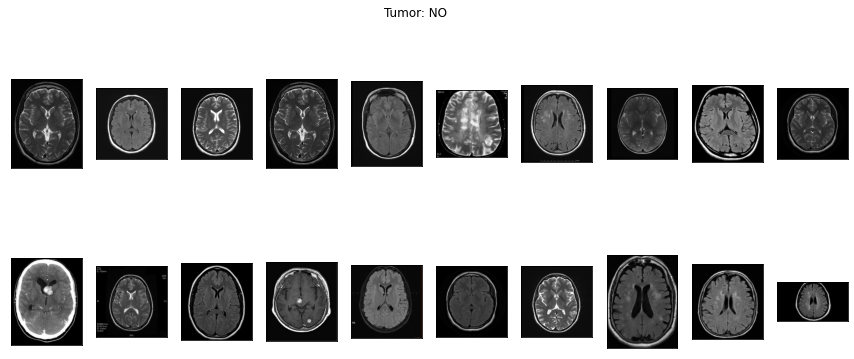

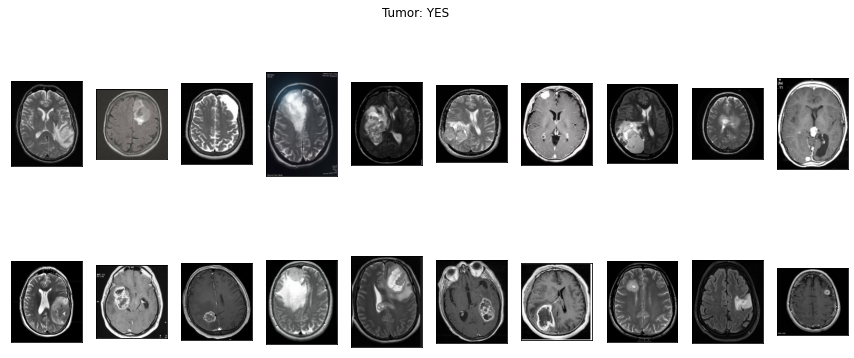

In [14]:
plotS(X_train, y_train, labels, 20)

In [7]:
# from pyimagesearch https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
def cropS(inp):
    new = []
    for img in inp:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        
        Left = tuple(c[c[:, :, 0].argmin()][0])
        Right = tuple(c[c[:, :, 0].argmax()][0])
        Top = tuple(c[c[:, :, 1].argmin()][0])
        Bot = tuple(c[c[:, :, 1].argmax()][0])
        
        ADD_PIXELS = 0
        new_img = img[Top[1]-ADD_PIXELS:Bot[1]+ADD_PIXELS, Left[0]-ADD_PIXELS:Right[0]+ADD_PIXELS].copy()
        new.append(new_img)

    return np.array(new)

/home/drex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


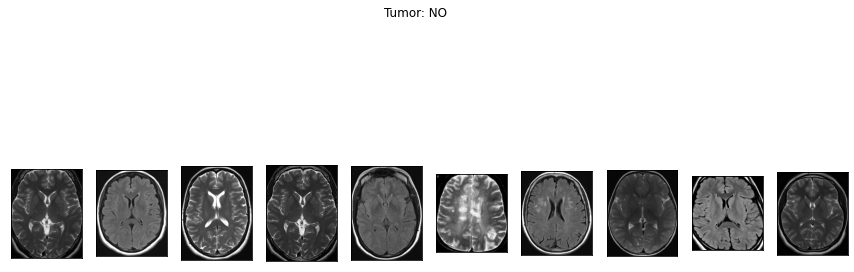

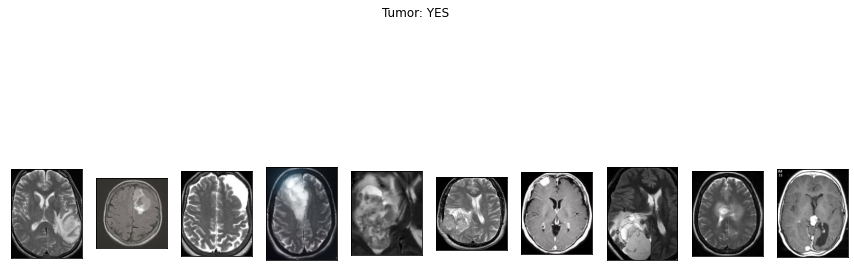

In [10]:
X_train_crop = cropS(X_train)
X_val_crop = cropS(X_val)
X_test_crop = cropS(X_test)
plotS(X_train_crop, y_train, labels, 10)

In [12]:
# def save_new_images(x_set, y_set, folder_name):
#     i = 0
#     for (img, imclass) in zip(x_set, y_set):
#         if imclass == 0:
#             cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
#         else:
#             cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
#         i += 1
# save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
# save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
# save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [16]:
def preprocess_imgs(inp, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    new = []
    for img in inp:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        new.append(tf.keras.applications.vgg16.tf.keras.applications.vgg16.preprocess_input(img))
    return np.array(new)
X_train_prep = preprocess_imgs(X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(X_val_crop, img_size=IMG_SIZE)

In [20]:

TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=123
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=123
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
# Definition 
model = tf.keras.Sequential()

In [ ]:
# Compile 
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics='accuracy')